**Predições dos valores de ações**

Esse notebook tem o intuito de prever os valores de fechamento do preço das ações da Bolsa de Valores B3.

Resumo do projeto em partes:

1º: Dividir uma parte dos dados disponível (arquivo Hist_Ações_BR.xlsx) em treino e teste. Com os dados de treino verificar qual o melhor modelo de regressão se aplica àquela ação.

2º: Aplicar o melhor modelo encontrado, de cada ação, sobre toda a base de dados disponível da ação. Predizer o valor de fechamento do próximo dia útil a partir dos valores de Abertura, Máximo e Mínimo de cada ação.

3º: O resultado apresentado, ordenado pelos maiores ganhos, indica as ações que sofrerão maiores altas e quais terão baixas.

Abaixo as importações necessárias as quais serão utilizadas ao longo desse notebook:

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings("ignore")

Os dados importados possuem as seguintes descrições:

Hist_Ações_BR.xlsx: contém toda a base de dados histórica das 13 ações mais negociadas na Bolsa de Valores.

ações_dia.xlsx: Possui o mesmo formato de colunas que o arquivo anterior, porém só possui os dados do dia útil seguinte, para cada uma das 13 ações.

In [ ]:
ações = pd.read_excel('/Users/rafaelferri/Arquivos/Bolsa/Hist_Ações_BR.xlsx')
ações_dia = pd.read_excel('/Users/rafaelferri/Arquivos/Bolsa/ações_dia.xlsx')
ações.index = ações['Date']
ações_dia.index = ações_dia['Date']
ações.drop(['Date'], axis=1, inplace=True)
ações_dia.drop(['Date'], axis=1, inplace=True)

nome_ações = ações.groupby('Name')['Name'].count()
ações = [ações[ações['Name']==acao] for acao in nome_ações.index]
nome_ações_dia = ações_dia.groupby('Name')['Name'].count()
ações_dia = [ações_dia[ações_dia['Name']==acao] for acao in nome_ações_dia.index]

Divisão dos dados entre Treino e Teste.
Aqui poderia ser utilizado o método sklearn.model_selection.train_test_split, porém o intuíto foi dar enfâse ao "corte" de 30 dias: o treino é todo dado até 30 dias antes da última data e a data-base de teste são os 30 dias retirados da base completa.

A seguir o dados são testados nos principais modelos de regressão e seus resultados (scores) são salvos em um DataFrame chamado scores.
Por fim, é encontrado o valor máximo de score de cada regressão e salvo no DataFrame melhor_modelo:

In [ ]:
AçõesTreino = [ações[n][:-30] for n in range(13)]
Açõesteste = [ações[n][-30:] for n in range(13)]

linhas_score = ["Linear", "Linear Std", "Linear MinMax",
                 "Ridge", "Ridge Std", "Ridge MinMax",
                "Lasso", "Lasso Std", "Lasso MinMax",
               "SVR_rbf", "SVR_rbf Std", "SVR_rbf MinMax"]
scores = pd.DataFrame(data = None, index = linhas_score, columns = range(13))

for stock in range(13):
    
    for mod, regr in [0,0], [1,3], [2,6], [3,9]:
        
        X = AçõesTreino[stock][['Open', 'High', 'Low']]
        y = AçõesTreino[stock]['Close']
        Xt = Açõesteste[stock][['Open', 'High', 'Low']]
        yt = Açõesteste[stock]['Close']
    
        if mod == 0:
            model = LinearRegression()
        elif mod == 1:
            model = Ridge(alpha=0.01)
        elif mod == 2:
            model = Lasso(alpha=0.01)
        elif mod == 3:
            model = SVR(kernel = 'rbf', C=1000, gamma=0.1)
    
        model.fit(X, y)
        scores[stock][regr] = model.score(Xt, yt)*100
        pipeline_S = Pipeline([('Scaler', StandardScaler()), ('Model', model)])
        pipeline_S.fit(X, y)
        scores[stock][regr+1] = pipeline_S.score(Xt, yt)*100
        pipeline_M = Pipeline([('MinMax', MinMaxScaler()), ('Model', model)])
        pipeline_M.fit(X, y)
        scores[stock][regr+2] = pipeline_M.score(Xt, yt)*100


melhor_modelo = pd.DataFrame(data = None, index = nome_ações.index, columns = ['Melhor Modelo'])
for a in range(13):
    for n in range(12):
        x = scores[a][n]
        if x == scores[a].max():
            melhor_modelo['Melhor Modelo'][a] = n

Abaixo os valores dos DataFrames gerados anteriormente e uma análise gráfica da performance do melhor modelo de regressão:

In [12]:
scores

,0,1,2,3,4,5,6,7,8,9,10,11,12
Linear,93.583,93.9866,94.5454,98.256,90.5379,88.9186,86.706,97.9007,97.7011,96.8096,97.2429,94.8288,97.1584
Linear Std,93.583,93.9866,94.5454,98.256,90.5379,88.9186,86.706,97.9007,97.7011,96.8096,97.2429,94.8288,97.1584
Linear MinMax,93.583,93.9866,94.5454,98.256,90.5379,88.9186,86.706,97.9007,97.7011,96.8096,97.2429,94.8288,97.1584
Ridge,93.5849,93.9884,94.5456,98.256,90.536,88.9184,86.7059,97.9006,97.7011,96.8098,97.2431,94.8287,97.1584
Ridge Std,93.5898,94.0301,94.5615,98.2501,90.5329,88.9162,86.696,97.8994,97.7013,96.8101,97.2507,94.8243,97.1397
Ridge MinMax,93.6913,94.6096,94.4496,98.1392,90.3711,88.8068,86.4244,97.8649,97.6863,96.8025,97.2394,94.592,96.6491
Lasso,91.9904,94.8565,93.167,97.2387,87.2918,83.9606,86.5943,97.6285,95.4707,95.0564,96.9996,95.0973,93.8889
Lasso Std,91.9634,93.6818,90.7758,96.778,87.1491,84.048,77.9588,97.0634,95.4296,94.9685,96.0494,93.2495,93.4209
Lasso MinMax,91.2919,92.1341,89.9785,96.859,85.6744,83.5956,78.9698,97.1508,93.2605,93.8449,96.034,92.7882,93.4499
SVR_rbf,91.7489,87.1912,62.6944,92.5904,91.8843,87.9942,83.1238,98.0735,-1891.77,97.0074,96.6173,66.5792,96.1042


In [13]:
melhor_modelo

,Melhor Modelo
Name,
AMBEV,5
B3,6
BANCO BRASIL,4
BR FOODS,1
BR MALLS,9
CCR,11
ESTACIO,2
HYPERMARCAS,9
JBS,4


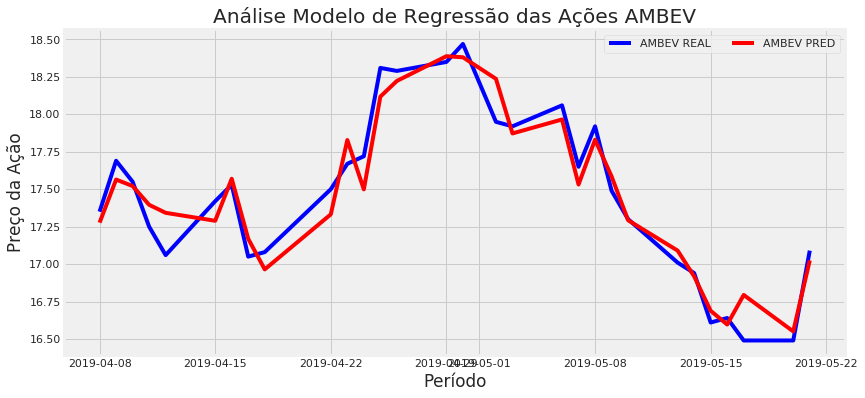

In [15]:
X = AçõesTreino[0][['Open', 'High', 'Low']]
y = AçõesTreino[0]['Close']
Xt = Açõesteste[0][['Open', 'High', 'Low']]
yt = Açõesteste[0]['Close']
pipeline_M = Pipeline([('MinMax', MinMaxScaler()), ('Model', Ridge(alpha=0.01))])
pipeline_M.fit(X, y)

plt.figure(figsize=(14,6))
plt.style.use('fivethirtyeight')
plt.plot(Açõesteste[0].index, Açõesteste[0]['Close'], color='blue', label='AMBEV REAL')
plt.plot(Açõesteste[0].index, pipeline_M.predict(Xt), color='red', label='AMBEV PRED')
plt.title("Análise Modelo de Regressão das Ações AMBEV")
plt.xlabel("Período")
plt.ylabel('Preço da Ação')
plt.legend(loc='best', ncol=2)

Finalmente os dados, agora completos oriundos da planilha Hist_Ações_BR.xlsx, são aplicados nos seus respectivos melhores modelos de regressão e preditos com os dados da planilha ações_dia.xlsx.

Esse valor, previsto pelo modelo, é subtraído do último valor de fechamento da ação, indicando o aumento ou queda no seu preço.

In [9]:
colunas_resultado = ['Preço Anterior', 'Previsão Preço', 'Aumento / Queda']
resultado = pd.DataFrame(data = None, index = nome_ações_dia.index, columns = colunas_resultado)

for n in range(13):
    modelo_selecionado = melhor_modelo['Melhor Modelo'][n]
    
    X = ações[n][['Open', 'High', 'Low']]
    y = ações[n]['Close']
    Xt = ações_dia[n][['Open', 'High', 'Low']]
    
    if modelo_selecionado == 0:
        model = LinearRegression()
        model.fit(X, y)
    elif modelo_selecionado == 1:
        model = Pipeline([('Scaler', StandardScaler()), ('Model', LinearRegression())])
        model.fit(X, y)
    elif modelo_selecionado == 2:
        model = Pipeline([('MinMax', MinMaxScaler()), ('Model', LinearRegression())])
        model.fit(X, y)
    elif modelo_selecionado == 3:
        model = Ridge(alpha=0.01)
        model.fit(X, y)
    elif modelo_selecionado == 4:
        model = Pipeline([('Scaler', StandardScaler()), ('Model', Ridge(alpha=0.01))])
        model.fit(X, y)
    elif modelo_selecionado == 5:
        model = Pipeline([('MinMax', MinMaxScaler()), ('Model', Ridge(alpha=0.01))])
        model.fit(X, y)
    elif modelo_selecionado == 6:
        model = Lasso(alpha=0.01)
        model.fit(X, y)
    elif modelo_selecionado == 7:
        model = Pipeline([('Scaler', StandardScaler()), ('Model', Lasso(alpha=0.01))])
        model.fit(X, y)
    elif modelo_selecionado == 8:
        model = Pipeline([('MinMax', MinMaxScaler()), ('Model', Lasso(alpha=0.01))])
        model.fit(X, y)
    elif modelo_selecionado == 9:
        model = SVR(kernel = 'rbf', C=1000, gamma=0.1)
        model.fit(X, y)
    elif modelo_selecionado == 10:
        model = Pipeline([('Scaler', StandardScaler()), ('Model', SVR(kernel = 'rbf', C=1000, gamma=0.1))])
        model.fit(X, y)
    elif modelo_selecionado == 11:
        model = Pipeline([('MinMax', MinMaxScaler()), ('Model', SVR(kernel = 'rbf', C=1000, gamma=0.1))])
        model.fit(X, y)
        
    resultado['Preço Anterior'][n] = ações[n]['Close'][-1]
    resultado['Previsão Preço'][n] = round(float(model.predict(Xt)),2)
    resultado['Aumento / Queda'][n] = resultado['Previsão Preço'][n] - resultado['Preço Anterior'][n]

In [17]:
dia = ações_dia[0].index
Meses=('','Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro')
resultado = resultado.sort_values(by = 'Aumento / Queda', ascending=False)

print('*'*30)
print("Previsões para o dia " + str(dia[0].day) + " de " + str(Meses[dia[0].month]) + " de " + str(dia[0].year), '\n')
print('*'*30)
resultado

******************************
Previsões para o dia 22 de Maio de 2019 

******************************


,Preço Anterior,Previsão Preço,Aumento / Queda
Name,,,
VALE,47.41,48.49,1.08
ESTACIO,28.1,28.84,0.74
JBS,22.4,23.01,0.61
BR FOODS,30.04,30.24,0.2
MRV,15.95,16.08,0.13
AMBEV,17.09,17.16,0.07
CCR,12.8,12.85,0.05
BR MALLS,12.21,12.19,-0.02
B3,34.32,34.26,-0.06
